In [1]:
from transformers import AutoTokenizer, AutoModel
import senteval
import torch
import torch.nn as nn
import json
import os

fs = os.listdir("..")
if not "SentEval" in fs:
    %cd ./..
    !git clone git@github.com:facebookresearch/SentEval.git
    %cd notebooks
    %mkdir data

PATH_TO_DATA = "../SentEval/data"
DEVICE = "cuda:0"

# ELECTRA

In [2]:
def batch_to_device(d, device):
    return {k: v.to(device) for k, v in d.items()}
    
class MeanPooling(nn.Module):
    def __init__(self, starting_state):
        super().__init__()
        self.starting_state = starting_state

    def forward(self, x, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(x.size()).float()
        emb_sum = torch.sum(x * input_mask_expanded, dim=1)
        sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9) # denominator
        emb_mean = emb_sum / sum_mask
        return emb_mean

class Electra:

    def __init__(self, starting_state=12, path=None):
        self.tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
        if path is None:
            self.model = AutoModel.from_pretrained("google/electra-base-discriminator").to(DEVICE)
        else:
            self.model = torch.load(path).to(DEVICE)
        self.pooling = MeanPooling(starting_state)
    
    def prepare(self, params, samples):
        pass 
    
    @torch.no_grad()
    def batcher(self, params, batch):
        tokenized_batch = self.tokenizer(
            batch, truncation=True, padding=True, return_tensors="pt", is_split_into_words=True
        )
        batch_device = batch_to_device(tokenized_batch, DEVICE)
        out = self.model(
            **batch_device, output_hidden_states=True
        ).hidden_states[self.pooling.starting_state]
        out_mean = self.pooling(out, batch_device["attention_mask"])
        return out_mean.cpu()



In [3]:
models = [
    "model_2024_01_18_01_15",
    "model_2024_01_18_01_17",
    "model_2024_01_18_01_18",
    "model_2024_01_18_01_20",
    "model_2024_01_18_01_22",
    "model_2024_01_18_01_24",
    "model_2024_01_18_01_26",
    "model_2024_01_18_01_29",
    "model_2024_01_18_01_31",
    "model_2024_01_18_01_34",
    "model_2024_01_18_01_37",
    "model_2024_01_18_01_40",
    "model_2024_01_17_16_15",
]

In [7]:
word_content_electra = []
for i, model_path in enumerate(models):
    params = {'task_path': PATH_TO_DATA, 'usepytorch': True, 'kfold': 10}
    params['classifier'] = {'nhid': 0, 'optim': 'adam', 'batch_size': 64, 'tenacity': 5, 'epoch_size': 4}

    electra = Electra(starting_state=i, path=f"../output/google-electra-base-discriminator/mean/{i}_to_{i+1}/{model_path}.pkl")
    se = senteval.engine.SE(params, electra.batcher, electra.prepare)

    transfer_tasks = [
        'WordContent', 
    ]

    results = se.eval(transfer_tasks)
    print(f"Starting state {i} -- {results['WordContent']['devacc']}")
    word_content_electra.append(results["WordContent"]["devacc"])

Starting state 7 -- 47.46
Starting state 8 -- 44.25
Starting state 9 -- 38.11
Starting state 10 -- 34.15
Starting state 11 -- 32.07
Starting state 12 -- 24.14


In [8]:
vals=[96.8,90.06,78.63,73.76,68.59,59.57,54.65,
     47.46,44.25,38.11,34.15,32.07,24.14]

print(len(vals))

13


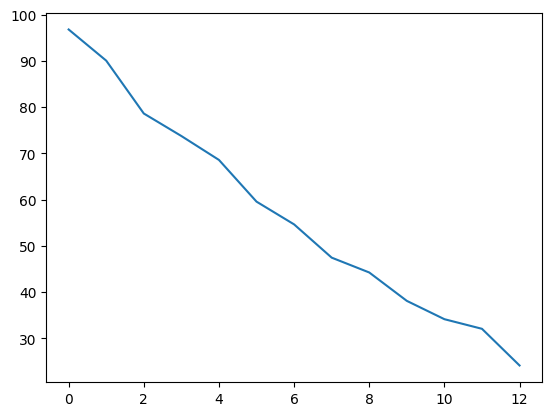

In [10]:
import matplotlib.pyplot as plt

plt.plot(vals)

In [ ]:
plt.plot(list(range(len(word_content_electra)), word_content_electra)